In [1]:
from src.helpers import setup_env

# If running locally, this will download dataset (make sure you have at 
# least 2 Gb of space on your hard drive)
setup_env()

GPU available


preparing data: 100%|███████████████████████| 1440/1440 [39:42<00:00,  1.65s/it]


In [1]:
from moviepy.editor import VideoFileClip
clip=VideoFileClip("data/archive (1)/RAVDESS dataset/Video_Speech_Actor_01/Actor_01/01-01-05-01-01-01-01.mp4").resize(width=256,height=256)
clip.fps
#clip.ipython_display()

29.97002997002997

In [2]:
sr=8000
ad=clip.subclip(t_start=1,t_end=1.2).audio.to_soundarray(fps=sr)
ad.shape

(1600, 2)

In [3]:
ad.shape[0]/clip.duration

410.2564102564103

In [4]:
import librosa
mel=librosa.feature.melspectrogram(y=ad, sr=sr )
mel.shape

(1600, 128, 1)

In [5]:
mel.min()

0.0

In [15]:
mel.dtype

dtype('float64')

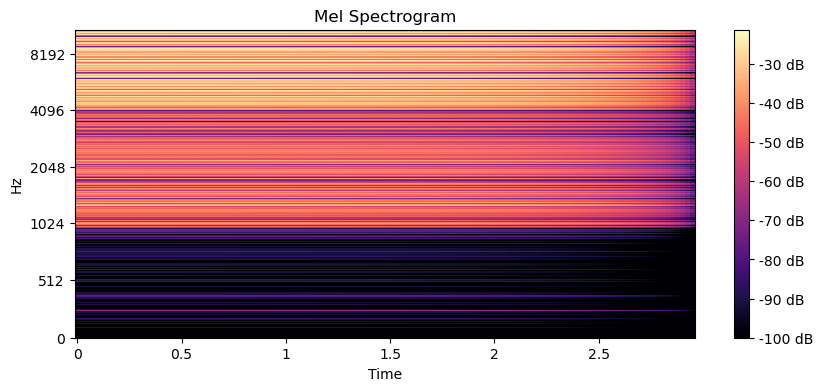

In [21]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 4))
log_mel_spectrogram = librosa.power_to_db(mel.squeeze(axis=2)).astype(np.float32)
librosa.display.specshow(log_mel_spectrogram, y_axis='mel', x_axis='time')
plt.colorbar(format="%+2.f dB")
plt.title("Mel Spectrogram")
plt.show()

In [1]:
%matplotlib inline
from src.data import visualize_one_batch, get_data_loaders

# use get_data_loaders to get the data_loaders dictionary. Use a batch_size
# of 5, a validation size of 0.01 and num_workers=-1 (all CPUs)
data_loaders = get_data_loaders(batch_size=2, num_workers=2)
print(len(data_loaders['train']))

Dataset mean: tensor([0.4850, 0.4560, 0.4060]), std: tensor([0.2290, 0.2240, 0.2250])
13006


In [2]:
images, labels=next(iter(data_loaders['train']))
len(labels.unique())

torch.Size([3, 256, 455])torch.Size([3, 256, 455])

torch.Size([3, 256, 455])torch.Size([3, 256, 455])

torch.Size([3, 256, 455])torch.Size([3, 256, 455])

torch.Size([3, 256, 455])torch.Size([3, 256, 455])



2

In [3]:
len(labels)

128

In [1]:
print_model=0
batch_size = 512  # size of the minibatch for stochastic gradient descent (or Adam)
num_epochs = 20     # number of epochs for training
num_classes = 8       # number of classes. Do not change this
learning_rate =0.05*(0.6)**0  # Learning rate for SGD (or Adam)
weight_decay = 0.001     # regularization. Increase this to combat overfitting
momentum=0.9 
accumulation_steps=2
model_name= "MyModel2"

suffix=''

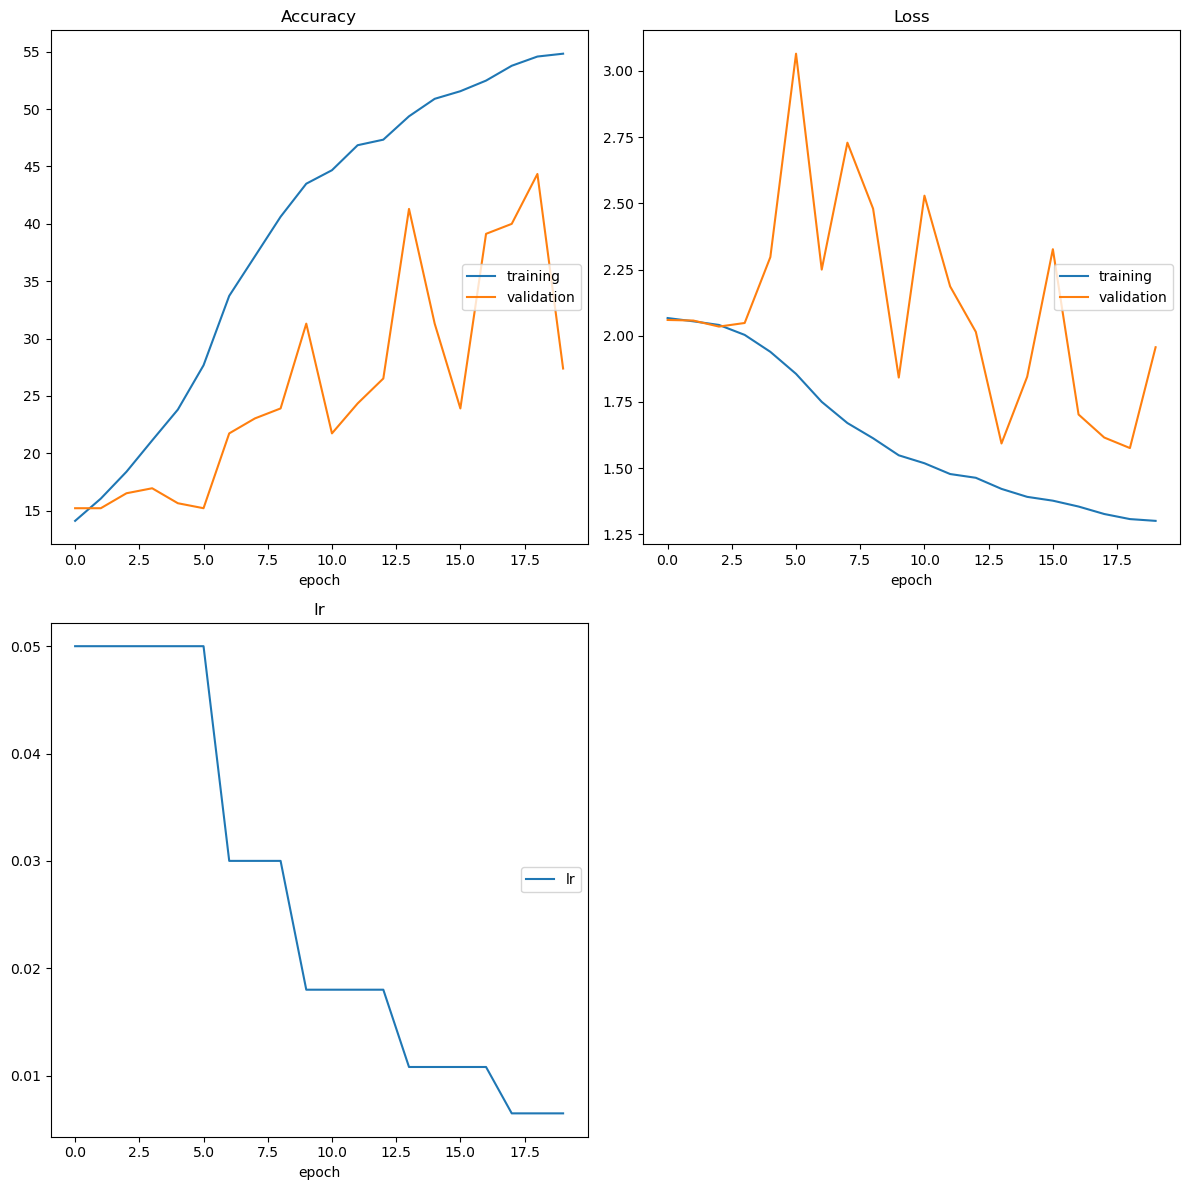

Epoch: 20 	Training Loss: 1.301052 	Validation Loss: 1.956761	Training Acc: 54.831 	Validation Acc: 27.391	Training 5Acc: 93.640 	Validation 5Acc: 88.696


In [2]:
from src.data import get_data_loaders
from src.train import optimize
from src.helpers import load_model, replace_insatance
import torch.nn.functional as F
import src.model as models
from torch.optim import lr_scheduler
import torch



data_loaders = get_data_loaders(batch_size=batch_size, is_mel=False)
torch.backends.cuda.matmul.allow_tf32=True
torch.backends.cudnn.allow_tf32=True

model = getattr(models, model_name)(num_classes=num_classes)
# initialize
def init_weights(m):
    if isinstance(m, torch.nn.Conv2d):
        torch.nn.init.orthogonal_(m.weight)

model.apply(init_weights)
# Get the optimizer using get_optimizer and the model you just created, the learning rate,
# the optimizer and the weight decay specified in the previous cel
optimizer = torch.optim.SGD(model.parameters(),lr=learning_rate,momentum=momentum,weight_decay=weight_decay,)


#milestones=[5,9,12, *range(12,num_epochs,2)]
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.6, patience=2,threshold=1e-3,verbose=True)
#scheduler = lr_scheduler.ExponentialLR(optimizer,gamma=0.7)

def step(loss ,epoch=None):
    scheduler.step(loss)

def loss(output,target):
    #target=F.one_hot(target, num_classes).float()
    return F.cross_entropy(output, target,label_smoothing=0.03)




s_epoch=load_model(model_name+suffix,model)
if print_model:
    print(f"model {model_name} has :{sum(p.numel() for p in model.parameters())/1e6} M parameters ")
    print(f"Effictive W>0.01 precentage: ")
    print('\n'.join('layer {} has : {}'.format(n,torch.sum(torch.abs(p)>0.01)/p.numel()) for n, p in model.named_parameters()))
#replace_insatance(model,torch.nn.LeakyReLU, models.Swish())
#print(model)

optimize(
    data_loaders,
    model,
    optimizer,
    loss,
    s_epoch=s_epoch,
    n_epochs=num_epochs,
    model_name=model_name+suffix,
    step=step,
    accumulation_steps=accumulation_steps,
    run_logs=False,
    interactive_tracking=True
    
)

In [3]:

# Get the loss using get_loss
loss = get_loss()

optimize(
    data_loaders,
    model,
    optimizer,
    loss,
    n_epochs=num_epochs,
    save_path="checkpoints/M3_best_val_loss.pt",
    run_logs=True,
    patience=2
)

Training:   0%|                                        | 0/1252 [00:00<?, ?it/s]

In [3]:

from src.train import one_epoch_test
one_epoch_test(data_loaders['test'], model, loss)

Testing: 100%|████████████████████████████████| 144/144 [00:13<00:00, 10.40it/s]

Test Loss: 0.160225


Test Accuracy: 91% (4188/4600)


0.1602245857163023

In [5]:
torch.save(model.state_dict(),'checkpoints/v2_best_val_loss.pt')

In [1]:
# NOTE: you might need to restart the notebook before running this step
# If you get an error about RuntimeError: Can't redefine method: forward on class
# restart your notebook then execute only this cell
from src.predictor import Predictor
from src.helpers import compute_mean_and_std
from src.model import MyModel4
from src.data import get_data_loaders
import torch

data_loaders = get_data_loaders(batch_size=1)

# First let's get the class names from our data loaders
class_names = data_loaders["train"].dataset.classes


# Then let's move the model_transfer to the CPU
# (we don't need GPU for inference)
model = MyModel4(num_classes=1).cpu()

# Let's make sure we use the right weights by loading the
# best weights we have found during training
# NOTE: remember to use map_location='cpu' so the weights
# are loaded on the CPU (and not the GPU)

model.load_state_dict(torch.load('checkpoints/v4_best_val_loss.pt'))

# Let's wrap our model using the predictor class
mean, std = compute_mean_and_std()
predictor = Predictor(model, class_names, mean, std).cpu()


# dummy_input = torch.zeros(1,3,256,256)
# # inputs = ['images']
# # outputs = ['scores']
# # dynamic_axes= {'input':{0:'batch_size' , 2:'width', 3:'height'}, 'output':{0:'batch_size' , 2:'width', 3:'height'}}
# torch.onnx.export(predictor, dummy_input, 'model.onnx', verbose=True)


# Export using torch.jit.script
scripted_predictor =torch.jit.script(predictor) 

scripted_predictor.save("checkpoints/original_exported.pt")

Reusing cached mean and std
Dataset mean: tensor([0.4690, 0.3993, 0.3567]), std: tensor([0.3180, 0.3058, 0.3087])
Reusing cached mean and std


/home/naif/miniconda3/envs/MLenv/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/naif/miniconda3/envs/MLenv/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ShuffleNet_V2_X1_0_Weights.IMAGENET1K_V1`. You can also use `weights=ShuffleNet_V2_X1_0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [14]:
from src.predictor import predictor_test

pred, truth = predictor_test(data_loaders['test'], model_reloaded)

  0%|                                          | 1/1819 [00:00<03:16,  9.26it/s]/home/naif/miniconda3/envs/MLenv/lib/python3.9/site-packages/torch/nn/modules/module.py:1130: UserWarning: operator() profile_node %373 : int = prim::profile_ivalue(%out_dtype.1)
 does not have profile information (Triggered internally at  /home/conda/feedstock_root/build_artifacts/pytorch-recipe_1664405705473/work/torch/csrc/jit/codegen/cuda/graph_fuser.cpp:104.)
  return forward_call(*input, **kwargs)
100%|███████████████████████████████████████| 1819/1819 [00:38<00:00, 47.69it/s]

Accuracy: 0.8834524463991204


Finally, let's have a look at the confusion matrix of the model we are going to use in production:

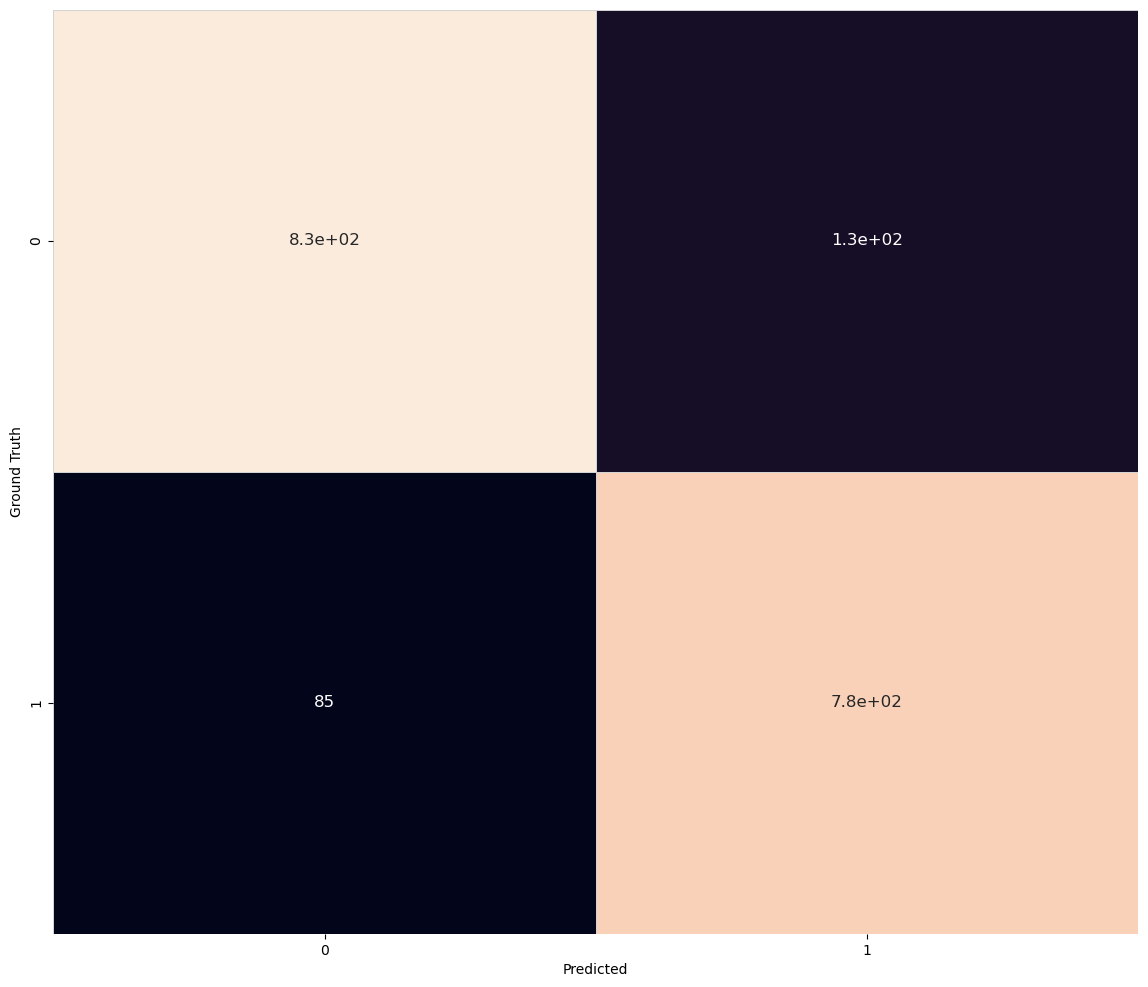

In [15]:
from src.helpers import plot_confusion_matrix

plot_confusion_matrix(pred, truth)